Stack all of the SDSS MaNGA rotation curves onto one plot.

In [1]:
import numpy as np

import astropy.units as u
import astropy.constants as const
from astropy.table import Table
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt

import os

# Path to RotationCurve libraries. Update as needed.
#rotcurvepath = os.path.join(os.environ['HOME'], 'desi/RotationCurves/spirals')
rotcurvepath = os.path.join(os.environ['HOME'], 'RotationCurves/spirals')
if not os.path.exists(rotcurvepath):
    raise FileNotFoundError(f'{rotcurvepath} does not exist.')

import sys
sys.path.insert(1, rotcurvepath)
from dark_matter_mass_v1 import rot_fit_BB

In [2]:
h = 1
H0 = 100*h*u.km/u.s/u.Mpc

c = const.c.to('km/s')

q0 = 0.2

MANGA_SPAXEL_SIZE = 0.5*u.arcsec

# Import data

## DESI

Need this to figure out which galaxies we want to include in the plot.

In [3]:
tf_targets = Table.read('/global/cfs/cdirs/desi/science/td/pv/desi_pv_tf_fuji_healpix.fits')

## SGA

In [4]:
SGA = Table.read('/global/cfs/cdirs/cosmo/data/sga/2020/SGA-2020.fits', 'ELLIPSE')

In [5]:
SGA_dict = {}

for i in range(len(SGA)):
    
    SGA_dict[SGA['SGA_ID'][i]] = i

## DESI-MaNGA cross-match file

In [6]:
SGA_MaNGA = Table.read('../MaNGA_SGA_crossmatch_2022-06-28.txt', format='ascii.commented_header')

SGA_MaNGA[:5]

plate,ifudsgn,plateifu,SGA_ID
int64,int64,str11,int64
8716,3703,8716-3703,927743
9086,6104,9086-6104,1003700
11967,1902,11967-1902,196166
8613,6104,8613-6104,376271
10001,3703,10001-3703,937846


## SDSS MaNGA best fits

Nitya's fitting from 2023 on DR17

In [7]:
MaNGA_fits = Table.read('master_table_Halpha_BB_HI_H2_MxCG_R90_CMD.txt', 
                        format='ascii.commented_header')

MaNGA_fits[:5]

MaNGA_plate,MaNGA_IFU,NSA_plate,NSA_fiberID,NSA_MJD,NSA_index,NSA_ID,NSA_RA,NSA_DEC,NSA_ba,NSA_phi,NSA_redshift,NSA_Mstar,smoothness_score,ba_map,ba_err_map,phi_map,phi_err_map,Vsys_map,Vsys_err_map,x0_map,x0_err_map,y0_map,y0_err_map,Vmax_map,Vmax_err_map,alpha_map,alpha_err_map,Rturn_map,Rturn_err_map,M90_map,M90_err_map,M3p5_map,M3p5_err_map,rho_bulge_map,rho_bulge_err_map,R_bulge_map,R_bulge_err_map,M90_disk_map,M90_disk_err_map,M3p5_disk_map,M3p5_disk_err_map,NSA_elpetro_th90,chi2_map,chi2_disk_map,logHI,logHI200kms,WF50,WF50_err,map_fit_flag,DL_ttype,rabsmag_NSA,R90_kpc,MaNGA_sample,CMD_class,v_3p5,v_3p5_err,logH2_M,logH2_CG,logH2_CG_err
int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
10001,12701,448,450,51900,48157,51226,133.3710906116639,57.59842514455842,0.417013,69.2463,0.0392074,2685340000.0,1.560186343059074,0.8525269160441389,0.004661246847300842,61.88507825188626,0.07338042747869138,2.946989472970758,0.09848277794062997,38.7739389484797,0.022936739976051144,37.440940071078124,0.016138461970098106,183.15428191832711,2.8318738759310786,4.181226771589277,0.07058094055808059,2.2299464843830368,0.006099342053787376,10.637055736445056,9.856536145016422,11.185428134112588,10.663096428880776,318528356.25649077,10973819.90888883,1.1700697820493802,0.01234311518755433,10.054323200255043,8.681101900065409,10.119328135890797,8.780959524997495,9.852487564086914,10.529260284502032,10.529260284502032,10.350040435791016,-999.0,309.752973573684,50.84180796596384,1.5,6.564641952514648,-19.2112,5.614479609229095,2.0,1.0,183.14938552312165,24.91258446340628,-999.0,-999.0,-999.0
10001,12702,448,524,51900,48188,51261,133.68566986867248,57.48025032183927,0.598115,12.5169,0.0408108,4642460000.0,1.5619979358006435,0.6739844282455619,0.006739656007202572,188.3088174477578,0.16826186470866497,0.6765359119793715,0.23419562301556418,36.85326879733403,0.04204024887591865,37.98221005537202,0.05640746039294769,194.97775272347383,6.932242299930594,0.6629820156636723,0.04575759010348131,0.9585752877878831,0.07208969706038451,10.600037009816079,10.15080355502181,11.292909462167833,10.847252340042417,115971867.9868961,7747575.084882941,1.6956282295929506,0.03670610210595715,10.124313484194262,9.034999166941406,10.177811159857796,9.124034282826187,14.355437278747559,2.457986344552885,2.457986344552885,9.583724021911621,-999.0,273.50491644321835,6.866128229994085,3.5,4.730921268463135,-19.0722,8.515048082090281,2.0,2.0,168.30899596736322,29.53675151629983,-999.0,-999.0,-999.0
10001,12703,483,535,51924,55648,59078,136.01715996919202,57.09232917791099,0.378034,51.5052,0.0462094,9439710000.0,1.1414035570714935,0.868911357820688,0.0007131052643978732,56.79483322166177,0.08249999450764357,16.699456893928602,0.0963277859001372,36.558508375391675,0.020946818786307338,35.641571170832165,0.018071593708941423,369.9104377816068,1.1162754236338,1.0019694161891133,0.003716146716676395,2.2255004811754473,0.025995323685563534,11.32307263875663,10.727979027247507,11.98875372506019,11.44150293569664,494628915.16105384,13753186.951918408,1.3970129924747783,0.0114278522601265,10.546935338970071,9.081725877664413,10.558369569453301,9.103192513387299,14.743389129638672,57.98401438954021,57.98401438954021,9.775858879089355,-999.0,383.131393858277,32.519186623217024,2.5,4.756507873535156,-19.9387,9.902006982545116,2.0,1.0,347.745404077086,47.8247202374236,-999.0,-999.0,-999.0
10001,12704,483,456,51924,55616,59044,133.98996686918764,57.677967666915094,0.212315,81.0961,0.0141215,4218380000.0,1.2909390780165348,0.4055339772671592,0.0006001633102882991,85.11107958400

# Determine which galaxies to include

This will consist of all galaxies observed in the DESI PV survey that have an observation at both the cetner and $0.33R_{26}$.

## Separate the fuji data into center and off-center observations

In [8]:
tf_targets['SKY_FIBER_DIST'] = 0.
tf_targets['SKY_FIBER_DIST_R26'] = 0.

# For each SGA galaxy that has at least one observation, calculate the distance 
# for all of that galaxy's targets
for sga_id in np.unique(tf_targets['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = tf_targets['SGA_ID'] == sga_id
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_id]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center of the SGA 
    # galaxy
    #---------------------------------------------------------------------------
    SGA_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                          dec=SGA['DEC'][sga_idx], 
                          unit=u.degree)
    target_coords = SkyCoord(ra=tf_targets['RA'][obs_idx], 
                             dec=tf_targets['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(SGA_coords)
    
    tf_targets['SKY_FIBER_DIST'][obs_idx] = sep2d
    tf_targets['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------

In [9]:
centers_boolean = tf_targets['SKY_FIBER_DIST_R26'] < 0.1

centers = tf_targets[centers_boolean]
axis = tf_targets[~centers_boolean]

## Clean the fuji center observations

Only keep those with
* `DELTACHI2` > 25
* `ZWARN` == 0

In [10]:
good_centers = centers[(centers['DELTACHI2'] > 25) & (centers['ZWARN'] == 0)]

## If an SGA galaxy has at least one observation at its center, set the redshift of that galaxy

In [11]:
SGA['Z_DESI'] = np.nan
SGA['ZERR_DESI'] = np.nan

weights = 1./(good_centers['ZERR']**2)

for sga_id in np.unique(good_centers['SGA_ID']):
    
    # Find all the center observations of this galaxy
    obs_idx = good_centers['SGA_ID'] == sga_id
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[sga_id]
    
    # Set the redshift of this galaxy to be the weighted average redshift of all 
    # good center observations
    SGA['Z_DESI'][SGA_idx] = np.average(good_centers['Z'][obs_idx], 
                                        weights=weights[obs_idx])
    SGA['ZERR_DESI'][SGA_idx] = np.sqrt(1./np.sum(weights[obs_idx]))

In [12]:
SGA_MaNGA['Z_DESI'] = np.nan
SGA_MaNGA['ZERR_DESI'] = np.nan
SGA_MaNGA['R26'] = np.nan
SGA_MaNGA['BA'] = np.nan
SGA_MaNGA['PA'] = np.nan

for i in range(len(SGA_MaNGA)):
    
    # Find the row in SGA for this galaxy
    SGA_idx = SGA_dict[SGA_MaNGA['SGA_ID'][i]]
    
    # Set the redshift of this galaxy
    SGA_MaNGA['Z_DESI'][i] = SGA['Z_DESI'][SGA_idx]
    SGA_MaNGA['ZERR_DESI'][i] = SGA['ZERR_DESI'][SGA_idx]
    
    # Transfer R26 over to the SGA_MaNGA table
    SGA_MaNGA['R26'][i] = 0.5*SGA['D26'][SGA_idx]
    
    # Transfer b/a over to the SGA_MaNGA table
    SGA_MaNGA['BA'][i] = SGA['BA'][SGA_idx]
    
    # Transfer phi over to the SGA_MaNGA table
    SGA_MaNGA['PA'][i] = SGA['PA'][SGA_idx]

## Calculate the rotational velocities

In [13]:
axis['SKY_FIBER_DIST'] = 0.
axis['SKY_FIBER_DIST_R26'] = 0.
axis['V_ROT'] = np.nan
axis['V_ROT_ERR'] = np.nan


# For each SGA galaxy that has at least one center observation, calculate the 
# distance for all of that galaxy's targets
for sga_gal in np.unique(centers['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = axis['SGA_ID'] == sga_gal
    
    # Find galaxy index in SGA catalog
    sga_idx = SGA_dict[sga_gal]
    
    #---------------------------------------------------------------------------
    # Calculate distance between each observation and the center
    #---------------------------------------------------------------------------
    center_coords = SkyCoord(ra=SGA['RA'][sga_idx], 
                             dec=SGA['DEC'][sga_idx], 
                             unit=u.degree)
    target_coords = SkyCoord(ra=axis['RA'][obs_idx], 
                             dec=axis['DEC'][obs_idx], 
                             unit=u.degree)
    
    sep2d = target_coords.separation(center_coords)
    
    axis['SKY_FIBER_DIST'][obs_idx] = sep2d.to('radian')
    axis['SKY_FIBER_DIST_R26'][obs_idx] = 2*sep2d.to('arcmin')/(SGA['D26'][sga_idx]*u.arcmin)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Calculate rotational velocity
    #---------------------------------------------------------------------------
    # Use the average redshift of all center observations for the systemic velocity
    z_center = np.mean(SGA['Z_DESI'][sga_idx])
    z_err_center2 = SGA['ZERR_DESI'][sga_idx]**2

    # Calculate rotational velocity for all observations of the galaxy
    axis['V_ROT'][obs_idx] = c*(axis['Z'][obs_idx] - z_center)
    axis['V_ROT_ERR'][obs_idx] = c*np.sqrt(axis['ZERR'][obs_idx]**2 + z_err_center2)
    #---------------------------------------------------------------------------
    
    
    #---------------------------------------------------------------------------
    # Correct rotational velocities for inclination angle
    #---------------------------------------------------------------------------
    cosi2 = (SGA['BA'][sga_idx]**2 - q0**2)/(1 - q0**2)
    
    # Galaxies with b/a < q0
    if cosi2 < 0:
        cosi2 = 0
    
    axis['V_ROT'][obs_idx] /= np.sin(np.arccos(np.sqrt(cosi2)))
    #---------------------------------------------------------------------------

## Just keep those velocities measured at $0.33R_{26}$

In [14]:
axis_0p3 = axis[(axis['SKY_FIBER_DIST_R26'] > 0.3) & (axis['SKY_FIBER_DIST_R26'] < 0.4)]

## Remove "bad" rotational velocities

Good velocities are those with
* $10 < V < 1000$ km/s
* $\Delta V/V_{min} > 5$

In [15]:
axis_0p3_goodV = axis_0p3[(np.abs(axis_0p3['V_ROT']) < 1000) & (np.abs(axis_0p3['V_ROT']) > 10)]

In [16]:
good_deltaV = np.ones(len(axis_0p3_goodV), dtype=bool)

for sga_id in np.unique(axis_0p3_goodV['SGA_ID']):
    
    # Identify all galaxy targets on this galaxy
    obs_idx = axis_0p3_goodV['SGA_ID'] == sga_id
    
    n_obs = np.sum(obs_idx)
    
    if n_obs > 1:
        
        Vmin = np.min(np.abs(axis_0p3_goodV['V_ROT'][obs_idx]))
        Vmax = np.max(np.abs(axis_0p3_goodV['V_ROT'][obs_idx]))
        
        v_norm_min = np.abs(axis_0p3_goodV['V_ROT'][obs_idx])/Vmin
        v_norm_max = np.abs(axis_0p3_goodV['V_ROT'][obs_idx])/Vmax
        
        diff_matrix = np.abs(axis_0p3_goodV['V_ROT'][obs_idx]).reshape(n_obs, 1) - np.abs(axis_0p3_goodV['V_ROT'][obs_idx]).reshape(1, n_obs)
        
        diff_matrix_norm = diff_matrix/Vmin
        
        if np.any(np.abs(diff_matrix_norm) > 5.):
            
            # Remove all observations with DELTACHI2 < 25
            # Note: This also typically removes observations with ZWARN != 0
            deltachi2_idx = axis_0p3_goodV['DELTACHI2'] >= 25
            
            good_deltaV[obs_idx & ~deltachi2_idx] = False
            
            good_obs_idx = obs_idx & deltachi2_idx
            
            n_obs_good = np.sum(good_obs_idx)
            
            # Check to make sure that, if there are still multiple observations, they all satisfy our relative velocity criteria
            if n_obs_good > 1:
                
                Vmin = np.min(np.abs(axis_0p3_goodV['V_ROT'][good_obs_idx]))
                
                diff_matrix = np.abs(axis_0p3_goodV['V_ROT'][good_obs_idx]).reshape(n_obs_good, 1) - np.abs(axis_0p3_goodV['V_ROT'][good_obs_idx]).reshape(1, n_obs_good)
                
                diff_matrix_norm = diff_matrix/Vmin
                
                if np.any(np.abs(diff_matrix_norm) > 5.):
                    
                    # Set all of these so that we don't look at this galaxy
                    good_deltaV[good_obs_idx] = False
                    
axis_0p3_good = axis_0p3_goodV[good_deltaV]

## Remove any objects discarded from VI

In [17]:
VI_remove = Table.read('../../TF/SV/fuji_VI.txt', format='ascii.commented_header')

remove_targets = np.zeros(len(axis_0p3_good), dtype=bool)

for targetid in VI_remove['TARGETID']:
    
    remove_targets = remove_targets & (axis_0p3_good['TARGETID'] == targetid)
    
VI_axis_0p3_good = axis_0p3_good[~remove_targets]

print(len(VI_axis_0p3_good), len(np.unique(VI_axis_0p3_good['SGA_ID'])))

2307 1196


# Add these velocities to the SDSS MaNGA - SGA cross-match table

In [18]:
SGA_MaNGA['V_0p33R26'] = np.nan
SGA_MaNGA['V_0p33R26_ERR'] = np.nan

SGA_MaNGA['SKY_FIBER_DIST'] = np.nan

weights = 1./(VI_axis_0p3_good['V_ROT_ERR']**2)

for i in range(len(SGA_MaNGA)):
    
    # Does this galaxy have any observations?
    i_obs = VI_axis_0p3_good['SGA_ID'] == SGA_MaNGA['SGA_ID'][i]
    
    if np.sum(i_obs) > 0:
        
        # Average all velocities at this radius
        SGA_MaNGA['V_0p33R26'][i] = np.average(np.abs(VI_axis_0p3_good['V_ROT'][i_obs]), 
                                               weights=weights[i_obs])
        SGA_MaNGA['V_0p33R26_ERR'][i] = np.sqrt(1./np.sum(weights[i_obs]))
        
        # Copy over the distance from the center for this observation
        SGA_MaNGA['SKY_FIBER_DIST'][i] = np.average(VI_axis_0p3_good['SKY_FIBER_DIST'][i_obs])

# Add the MaNGA best-fit values to the table

In [19]:
SGA_MaNGA['Vmax_map'] = np.nan
SGA_MaNGA['Vmax_err_map'] = np.nan
SGA_MaNGA['Rturn_map'] = np.nan
SGA_MaNGA['alpha_map'] = np.nan

SGA_MaNGA['ba_map'] = np.nan
SGA_MaNGA['ba_err_map'] = np.nan
SGA_MaNGA['ba_NSA'] = np.nan

SGA_MaNGA['phi_map'] = np.nan
SGA_MaNGA['phi_err_map'] = np.nan
SGA_MaNGA['phi_NSA'] = np.nan

for i in range(len(SGA_MaNGA)):
    
    gal_id = SGA_MaNGA['plateifu'][i]
    
    # Find galaxy row in MaNGA fits table
    plate_bool = MaNGA_fits['MaNGA_plate'] == SGA_MaNGA['plate'][i]
    ifu_bool = MaNGA_fits['MaNGA_IFU'] == SGA_MaNGA['ifudsgn'][i]
    
    i_fit = plate_bool & ifu_bool
    
    # Copy best-fit parameter values from fit table to galaxy table
    if (np.sum(i_fit) > 0): #and (gal_id not in []):
        SGA_MaNGA['Vmax_map'][i] = MaNGA_fits['Vmax_map'][i_fit]
        SGA_MaNGA['Vmax_err_map'][i] = MaNGA_fits['Vmax_err_map'][i_fit]
        SGA_MaNGA['Rturn_map'][i] = MaNGA_fits['Rturn_map'][i_fit]
        SGA_MaNGA['alpha_map'][i] = MaNGA_fits['alpha_map'][i_fit]
        
        SGA_MaNGA['ba_map'][i] = MaNGA_fits['ba_map'][i_fit]
        SGA_MaNGA['ba_err_map'][i] = MaNGA_fits['ba_err_map'][i_fit]
        SGA_MaNGA['ba_NSA'][i] = MaNGA_fits['NSA_ba'][i_fit]
        
        SGA_MaNGA['phi_map'][i] = MaNGA_fits['phi_map'][i_fit]
        SGA_MaNGA['phi_err_map'][i] = MaNGA_fits['phi_err_map'][i_fit]
        SGA_MaNGA['phi_NSA'][i] = MaNGA_fits['NSA_phi'][i_fit]
        
# Flip all -99 values to NaN
SGA_MaNGA['Vmax_map'][SGA_MaNGA['Vmax_map'] == -999] = np.nan

In [20]:
good_V = np.isfinite(SGA_MaNGA['Vmax_map']) & np.isfinite(SGA_MaNGA['V_0p33R26'])

print(np.sum(good_V))

68


## Remove those galaxies that have poor fits

Bad fits are defined as those with
* $V(R_{26}) < 0.9V_{max}$
* $V_{max} > 1000$ km/s

In [21]:
# 1 - Convert R26 to kpc for each galaxy
dist_to_galaxy = SGA_MaNGA['Z_DESI']*c/H0
R26_kpc = dist_to_galaxy.to('kpc')*np.tan((SGA_MaNGA['R26']*u.arcmin).to(u.rad))

# 2 - Compute V(R26)
SGA_MaNGA['Vfit_R26'] = rot_fit_BB(R26_kpc.data, [SGA_MaNGA['Vmax_map'], SGA_MaNGA['Rturn_map'], SGA_MaNGA['alpha_map']])

# 3 - Filter out those with V(R26) < 0.9Vmax
goodVmax = SGA_MaNGA['Vfit_R26'] >= 0.9*SGA_MaNGA['Vmax_map']

# 4 - Filter out those with Vmax > 1000 km/s
lowVmax = SGA_MaNGA['Vmax_map'] < 1000.

final_sample = good_V & goodVmax & lowVmax

/global/homes/k/kadglass/RotationCurves/spirals/dark_matter_mass_v1.py:74: RuntimeWarning: divide by zero encountered in power
  v = v_max * (np.abs(depro_radius) / (r_turn**alpha + np.abs(depro_radius)**alpha)**(1/alpha))


# Plot

In [22]:
r = np.linspace(0, 1, 100) # units of R26

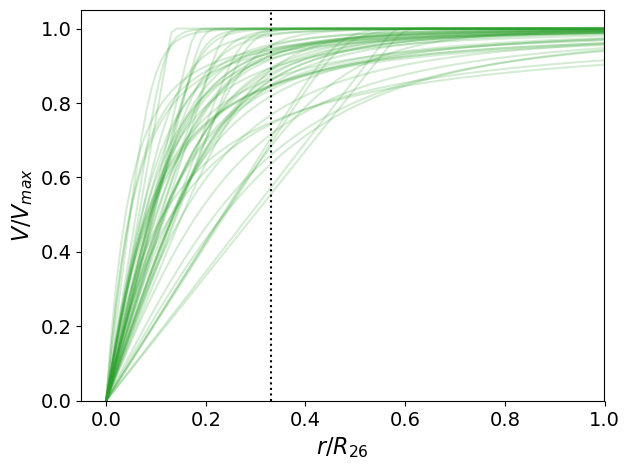

In [25]:
plt.figure(tight_layout=True)


# plt.grid(visible=True)

for i in range(np.sum(final_sample)):
    
    alpha = SGA_MaNGA['alpha_map'][final_sample][i]
    Rturn = SGA_MaNGA['Rturn_map'][final_sample][i]
    Vmax = SGA_MaNGA['Vmax_map'][final_sample][i]
    # Rmax = SGA_MaNGA['Rmax_map'][final_sample][i]
    
    Vr = rot_fit_BB(r*R26_kpc[final_sample][i].data, [Vmax, Rturn, alpha])
    
    plt.plot(r, Vr/Vmax, 'tab:green', alpha=0.2)
    
plt.vlines(0.33, 0, 1.1, colors='k', ls='dotted')
    
plt.xlim([-0.05, 1])
plt.ylim([0, 1.05])

plt.tick_params(axis='both', which='major', labelsize=14)

plt.xlabel('$r/R_{26}$', fontsize=16)
plt.ylabel('$V/V_{max}$', fontsize=16)

plt.savefig('../../Figures/MaNGA_dr17/SV_curves_20240105.png', dpi=150);